# Glaucoma Screening Service Prototype
#### Portfolio Project by Elizabeth Haynie

The aim of this prototype is to explore whether a deep neural architecture, VGG16, can be used to reliably screen for Glaucoma. 
<table>
    <tr>
        <th style="text-align:center;">Normal</th>
        <th style="text-align:center;">Glaucomatous</th>
    </tr>
    <tr><td><img style="width:224px; height:224px;" src='../Data/train/Im012_ACRIMA.jpg'></td>
   <td><img style="width:224px; height:224px;" src='../Data/train/Im493_g_ACRIMA.jpg'></td></tr>
    </table>

In [108]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import os
print(os.listdir("../Data"))
import random 
import warnings
from IPython.display import Image, HTML, display

#Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

['Raw', 'test', 'train', 'val']


## Split the Data into Test, Train and Validate Sets

In [109]:
base_dir="../Data/"
train_dir=base_dir+'train'
test_dir=base_dir+'test'
val_dir=base_dir+'val'

import sys
from PIL import Image
sys.modules['Image'] = Image 

In [110]:
# Checking image size, this is resized from [349, 349] to [224, 224] later
im = Image.open(test_dir + '/Im013_ACRIMA.jpg')
width, height = im.size
width, height

(349, 349)

In [111]:
def get_df(path):
    filenames = os.listdir(path)
    labels = []
    for i in filenames:
        if '_g_' in i:
            label = "glaucoma"
        else:
            label = "benign"

        labels.append([i, label])
    return pd.DataFrame(labels, columns=["id", "label"])

In [112]:
df_train = get_df(train_dir)
df_val = get_df(val_dir)
df_test = get_df(test_dir)
df_train.shape, df_val.shape, df_test.shape

((423, 2), (141, 2), (141, 2))

## Data Preprocessing

In [113]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=5, fill_mode='nearest', width_shift_range=0.05, height_shift_range=0.05, horizontal_flip=True, vertical_flip=True)
training_set = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                 directory=train_dir, 
                                                 target_size=(224,224),
                                                 x_col='id', 
                                                 y_col='label', 
                                                 shuffle=True,
                                                 class_mode='categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                 directory=test_dir, 
                                                 target_size=(224,224),
                                                 x_col='id', 
                                                 y_col='label', 
                                                 shuffle=True,
                                                 class_mode='categorical')


val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_dataframe(dataframe=df_val,
                                                 directory=val_dir, 
                                                 target_size=(224,224),
                                                 x_col='id', 
                                                 y_col='label', 
                                                 shuffle=True,
                                                 class_mode='categorical')


Found 423 validated image filenames belonging to 2 classes.
Found 141 validated image filenames belonging to 2 classes.
Found 141 validated image filenames belonging to 2 classes.


In [114]:
IMAGE_SIZE= [224,224]
vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + [3]
)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False

In [115]:
x = Flatten()(vgg.output)
prediction= Dense((2), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Model Training

In [116]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy', 
                       tf.keras.metrics.TruePositives(thresholds=None, name="true_positives"), 
                       tf.keras.metrics.FalsePositives(thresholds=None, name="false_positives"), 
                       tf.keras.metrics.TrueNegatives(thresholds=None, name="true_negatives"), 
                       tf.keras.metrics.FalseNegatives(thresholds=None, name="false_negatives"), 
                       tf.keras.metrics.SensitivityAtSpecificity(0.5)])
history=model.fit(training_set, validation_data=val_set, epochs=5, batch_size=32)

Epoch 1/5
14/14 [==============================] - 99s 7s/step - loss: 1.0259 - accuracy: 0.5485 - true_positives: 232.0000 - false_positives: 191.0000 - true_negatives: 232.0000 - false_negatives: 191.0000 - sensitivity_at_specificity_4: 0.5910 - val_loss: 0.8110 - val_accuracy: 0.4539 - val_true_positives: 64.0000 - val_false_positives: 77.0000 - val_true_negatives: 64.0000 - val_false_negatives: 77.0000 - val_sensitivity_at_specificity_4: 0.4326
Epoch 2/5
14/14 [==============================] - 96s 7s/step - loss: 0.5787 - accuracy: 0.6667 - true_positives: 282.0000 - false_positives: 141.0000 - true_negatives: 282.0000 - false_negatives: 141.0000 - sensitivity_at_specificity_4: 0.8629 - val_loss: 0.4680 - val_accuracy: 0.7376 - val_true_positives: 104.0000 - val_false_positives: 37.0000 - val_true_negatives: 104.0000 - val_false_negatives: 37.0000 - val_sensitivity_at_specificity_4: 0.9574
Epoch 3/5
14/14 [==============================] - 91s 6s/step - loss: 0.4102 - accuracy: 0.

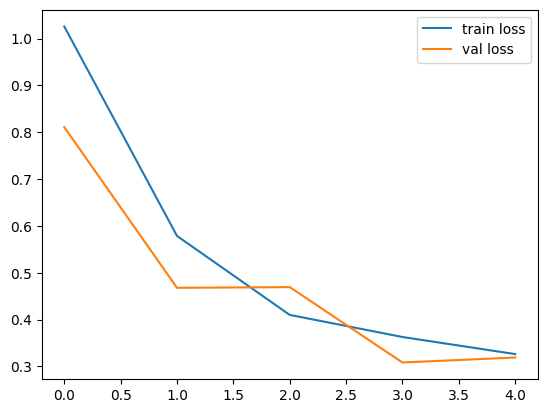

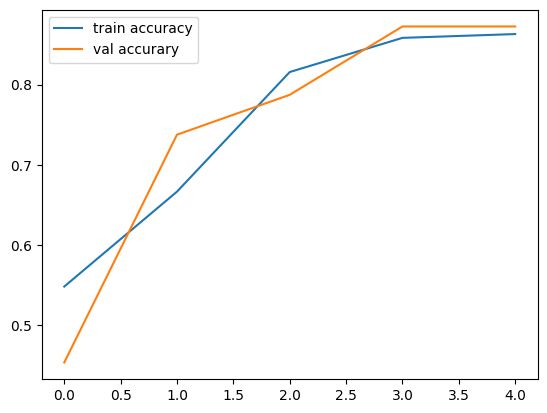

In [117]:
# Plot Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
 
# Plot Accuracies
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accurary')
plt.legend()
plt.show()

In [118]:
def specificity(true_neg, false_pos):
    result = true_neg/(true_neg + false_pos)
    return result

def sensitivity(true_pos, false_neg):
    result = true_pos/(true_pos + false_neg)
    return result

In [129]:
# Select the metric from the final Epoch
true_neg = history.history["true_negatives"][-1]
false_neg = history.history["false_negatives"][-1]
true_pos = history.history["true_positives"][-1]
false_pos = history.history["false_positives"][-1]
#true_neg,false_neg, false_pos, true_neg
history.history["true_negatives"],history.history["false_positives"], history.history["true_positives"]

([232.0, 282.0, 345.0, 363.0, 365.0],
 [191.0, 141.0, 78.0, 60.0, 58.0],
 [232.0, 282.0, 345.0, 363.0, 365.0])

## Model Sensitivity 

In [120]:
sensitivity(true_pos, false_neg)

0.8628841607565012

## Model Specificity

In [121]:
specificity(true_neg, false_pos)

0.8628841607565012

## Model Accuracy 

In [122]:
history.history['accuracy'][-1]

0.8628841638565063

In [123]:
#Save the model
from tensorflow.keras.models import load_model
model.save('glaucome-detection.h5')

In [1]:
#